# Imports

In [17]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

# Qiskit imports
import qiskit
reload(qiskit)
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile, execute
from qiskit.circuit.library import MCMT
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import random_statevector, random_unitary
import qiskit.tools.jupyter

plt.style.use('science')

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Auxiliary functions

In [4]:
def flip_keys(dic):
    ''' 
    Flips the strings in the keys of dictionary 'dic'. 
    example:
        >>> flip_keys({'011': 3, '001': 4})
        {'110': 3, '100': 4}
    '''
    new_dic = {}
    for key, value in dic.items():
        new_dic[key[::-1]] = value
    return new_dic

def bit_combinations(s):
    '''
    Input must be in the form '00.1000000', returns
    all possible bit strings of that form, having 0's
    and 1's in the place of '.'.
    example:
        >>> bit_combinations('00.1000000')
        ['0001000000', '0011000000']
    '''
    arr = np.array(list(s), dtype=object)
    dots_pos = np.where(arr == '.')[0]
    bit_lst = [list(''.join(str(bit) for bit in bits)) for bits in product([0, 1], repeat=len(dots_pos))]
    result = []
    for bit in bit_lst:
        arr[dots_pos] = bit
        result.append(''.join(str(b) for b in arr))
    return result

# Amplification - Simulator

Let's build our $\mathcal{W}$ and $\mathcal{W}^{\dagger}$ circuits.

In [108]:
A = random_unitary(2)
T = random_unitary(4)

W = QuantumCircuit(3)
W.unitary(A, 0)
W.unitary(T, [1, 2])

Wdag = QuantumCircuit(3)
Wdag.unitary(A.adjoint(), 0)
Wdag.unitary(T.adjoint(), [1, 2])

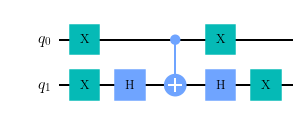

In [96]:
qr = QuantumRegister(2, 'q')
S = QuantumCircuit(qr)
S.x(qr)
S.h(1)
S.cnot(0, 1)
S.h(1)
S.x(qr)
S.draw()

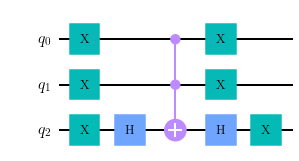

In [102]:
qr = QuantumRegister(3, 'q')
S0 = QuantumCircuit(qr)
S0.x(qr)
S0.h(-1)
S0.ccx(0, 1, 2)
S0.h(-1)
S0.x(qr)
S0.draw()

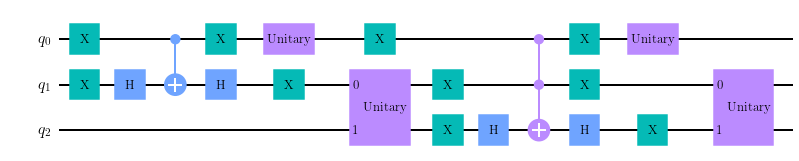

In [113]:
Q = QuantumCircuit(3)
Q.compose(S, [0, 1], inplace=True)
Q.compose(Wdag, inplace=True)
Q.compose(S0, inplace=True)
Q.compose(W, inplace=True)
Q.draw()

In [132]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)

qc.compose(W, inplace=True)

qc_measured = deepcopy(qc)
qc_measured.measure(qr[:2], cr)

# estimate probability a

shots = 20000
job = execute(qc_measured, backend=backend_sim, shots=shots)
counts = job.result().get_counts()
a = counts.get('00', 0)/shots

m = int(np.floor(np.pi/(4*np.arcsin(np.sqrt(a)))))

for i in range(m):
    qc.compose(Q, qr, inplace=True)
    
qc.measure(qr[:2], cr)

shots = 20000
job = execute(qc, backend=backend_sim, shots=shots)
counts = job.result().get_counts()
a = counts.get('00', 0)/shots
print(a)

0.98915


In [21]:
qr = QuantumRegister(2, 'q')
S = QuantumCircuit(qr)
S.x(qr)
S.h(1)
S.cnot(0, 1)
S.h(1)
S.x(qr)

qr = QuantumRegister(3, 'q')
S0 = QuantumCircuit(qr)
S0.x(qr)
S0.h(-1)
S0.ccx(0, 1, 2)
S0.h(-1)
S0.x(qr)

a_lst = []
p_lst = []

for i in range(1000):
    # build operators
    A = random_unitary(2)
    T = random_unitary(4)

    W = QuantumCircuit(3)
    W.unitary(A, 0)
    W.unitary(T, [1, 2])
    W.cx(0, 1)
    W.h(0)

    Wdag = QuantumCircuit(3)
    Wdag.unitary(A.adjoint(), 0)
    Wdag.unitary(T.adjoint(), [1, 2])
    W.h(0)
    W.cx(0, 1)
    
    Q = QuantumCircuit(3)
    Q.compose(S, [0, 1], inplace=True)
    Q.compose(Wdag, inplace=True)
    Q.compose(S0, inplace=True)
    Q.compose(W, inplace=True)
    Q.draw()
    
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(qr, cr)

    qc.compose(W, inplace=True)

    qc_measured = deepcopy(qc)
    qc_measured.measure(qr[:2], cr)

    shots = 20000
    job = execute(qc_measured, backend=backend_sim, shots=shots)
    counts = job.result().get_counts()
    a = counts.get('00', 0)/shots
    a_lst.append(a)

    m = int(np.floor(np.pi/(4*np.arcsin(np.sqrt(a)))))

    for i in range(m):
        qc.compose(Q, qr, inplace=True)

    qc.measure(qr[:2], cr)

    shots = 20000
    job = execute(qc, backend=backend_sim, shots=shots)
    counts = job.result().get_counts()
    p = counts.get('00', 0)/shots
    p_lst.append(p)
    
    print(a, p, m)

0.06065 0.9575 3
0.2172 0.9884 1
0.3732 0.8513 1
0.45115 0.6473 1
0.5184 0.51465 0
0.11345 0.986 2
0.193 0.95695 1
0.0961 0.9997 2
0.35075 0.88755 1
0.4121 0.75975 1
0.43075 0.71015 1
0.50005 0.4999 0
0.2617 0.99745 1
0.64245 0.6367 0
0.39575 0.7939 1
0.092 0.99965 2
0.3004 0.9751 1
0.4875 0.52755 1
0.0651 0.946 3
0.22725 0.99245 1
0.17585 0.92115 1
0.2634 0.9975 1
0.12965 0.9284 2
0.2662 0.99645 1
0.0755 0.9716 2
0.07865 0.97315 2
0.4019 0.76185 1
0.02775 0.98895 4
0.06285 0.9651 3
0.01035 1.0 7
0.3382 0.92305 1
0.0038 0.99105 12
0.35155 0.88675 1
0.60785 0.61205 0
0.2594 0.9993 1
0.5558 0.55005 0
0.24595 0.99985 1
0.5735 0.58335 0
0.4867 0.5493 1
0.06695 0.91735 3
0.12165 0.9557 2
0.2271 0.9941 1
0.2475 0.9998 1
0.30495 0.9699 1
0.2747 0.99035 1
0.63185 0.631 0
0.03805 0.96575 4
0.5118 0.5109 0
0.31355 0.96135 1
0.1972 0.96835 1
0.03115 0.9979 4
0.38845 0.81815 1
0.7948 0.79645 0
0.0818 0.97985 2
0.0561 0.9919 3
0.10505 0.9925 2
0.0464 0.9998 3
0.0986 0.99985 2
0.1891 0.9602 1
0.0228

0.3681 0.86655 1
0.07155 0.95475 2
0.15935 0.8881 1
0.1312 0.92115 2
0.12525 0.9483 2
0.44375 0.6692 1
0.7885 0.78805 0
0.02755 0.99545 4
0.20155 0.9679 1
0.17755 0.94505 1
0.12745 0.93595 2
0.04225 0.99315 3
0.57035 0.5679 0
0.1879 0.9467 1
0.5755 0.573 0
0.3318 0.9348 1
0.1303 0.9299 2
0.1829 0.94625 1
0.0491 0.9987 3
0.1461 0.8664 2
0.4191 0.7305 1
0.0703 0.9552 2
0.0272 0.99335 4
0.67915 0.68335 0
0.1204 0.9549 2
0.37755 0.84875 1
0.0744 0.96355 2
0.40115 0.78005 1
0.27365 0.99535 1
0.0277 0.994 4
0.03915 0.96865 3
0.42845 0.71695 1
0.0382 0.95985 3
0.23025 0.9961 1
0.45105 0.643 1
0.00575 0.99885 10
0.16925 0.9195 1
0.33825 0.90625 1
0.05465 0.99405 3
0.30115 0.9781 1
0.4135 0.7521 1
0.40075 0.79015 1
0.0828 0.9896 2
0.1232 0.9554 2
0.2424 0.9979 1
0.40265 0.76085 1
0.0826 0.9876 2
0.1743 0.924 1
0.4435 0.67415 1
0.183 0.9463 1
0.0643 0.9354 3
0.1515 0.87425 1
0.02505 0.9755 4
0.00315 0.99865 13
0.59025 0.598 0
0.07805 0.9717 2
0.2789 0.99 1
0.01395 0.9987 6
0.0802 0.98765 2
0.049

0.0765 0.9678 2
0.0012 0.9997 22
0.1377 0.88395 2
0.2145 0.98215 1
0.4616 0.6268 1
0.07185 0.94775 2
0.24275 0.99935 1
0.1862 0.94985 1
0.53925 0.53965 0
0.26605 0.9973 1
0.77885 0.7768 0
0.14755 0.85635 1
0.77285 0.78335 0
0.1757 0.92675 1
0.00735 0.9782 9
0.0228 0.9904 5
0.0803 0.98025 2
0.12855 0.93995 2
0.30855 0.9638 1
0.3098 0.959 1
0.4801 0.56425 1
0.09775 0.99795 2
0.25855 0.99815 1
0.0332 0.9901 4
0.2546 0.9993 1


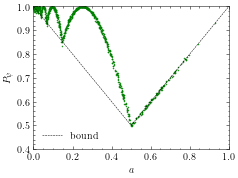

In [25]:
# fig = plt.figure(figsize=(10, 5))

a_line = [0, 0.5, 1]
p_line = [1, 0.5, 1]

plt.plot(a_lst, p_lst, 'g.', ms=1)
plt.plot(a_line, p_line, 'k--', lw=0.5, label='bound')
plt.xlim(0, 1)
plt.ylim(0.4, 1)

plt.xlabel(r'$a$')
plt.ylabel(r'$P_{\psi}$')
plt.legend()
plt.savefig('random_test', dpi=600)

In [179]:
for a, p in zip(a_lst, p_lst):
    print(a, p)

0.07665 0.97755
0.1312 0.9189
0.49365 0.5311
0.15685 0.88505
0.1553 0.8774
0.263 0.99745
0.2179 0.98685
0.28465 0.98755
0.07 0.94
0.47265 0.5923
0.16755 0.91435
0.1127 0.97455
0.001 0.9828
0.0084 0.9998
0.4531 0.64635
0.02725 0.98935
0.3988 0.7794
0.43335 0.6819
0.0744 0.9659
0.20055 0.97125
0.18115 0.9387
0.6472 0.6512
0.27505 0.9899
0.16885 0.91905
0.38875 0.79825
0.0914 0.99785
0.22555 0.99215
0.2309 0.9953
0.0191 0.9998
0.5571 0.5622
0.0444 0.99225
0.07945 0.9631
0.32855 0.9383
0.12835 0.9317
0.48095 0.57435
0.33545 0.93205
0.32815 0.93735
0.25025 0.9999
0.13145 0.9257
0.08045 0.99165
0.3457 0.908
0.16295 0.8983
0.0361 0.97875
0.2504 1.0
0.0762 0.9693
0.5319 0.52705
0.07435 0.95415
0.1565 0.87215
0.1987 0.96575
0.45445 0.65515
0.59755 0.6059
0.7004 0.6984
0.149 0.85575
0.24565 0.99965
0.36495 0.8606
0.95175 0.9512
0.51235 0.5139
0.11445 0.97825
0.1165 0.9634
0.1294 0.9349
0.0076 0.999
0.212 0.9843
0.36885 0.86655
0.2386 0.9972
0.1284 0.94515
0.0566 0.9867
0.45 0.66245
0.29755 0.982

In [26]:
arr = np.array([a_lst, p_lst]).transpose()
np.savetxt('random_test.txt', arr)

# Amplification - evolution ibm vs sim

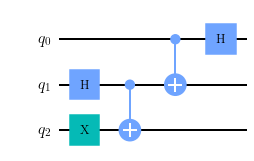

In [5]:
qr = QuantumRegister(2, 'q')
S = QuantumCircuit(qr)
S.x(qr)
S.h(1)
S.cnot(0, 1)
S.h(1)
S.x(qr)

qr = QuantumRegister(3, 'q')
S0 = QuantumCircuit(qr)
S0.x(qr)
S0.h(-1)
S0.ccx(0, 1, 2)
S0.h(-1)
S0.x(qr)

W = QuantumCircuit(3)
W.h(1)
W.x(2)
W.cx(1, 2)
W.cx(0, 1)
W.h(0)
W.draw()

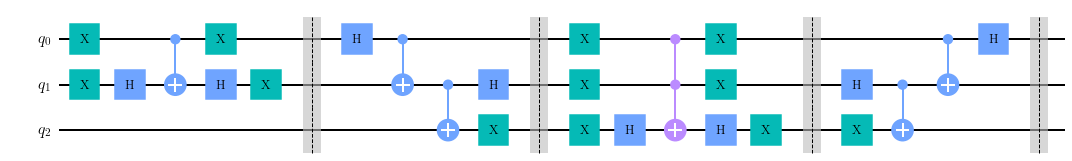

In [6]:
Q = QuantumCircuit(3)
Q.compose(S, [0, 1], inplace=True)
Q.barrier()
Q.compose(W.reverse_ops(), inplace=True)
Q.barrier()
Q.compose(S0, inplace=True)
Q.barrier()
Q.compose(W, inplace=True)
Q.barrier()
Q.draw()

In [7]:
Q = RemoveBarriers()(Q)

In [8]:
circ_lst = []

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)

qc.compose(W, inplace=True)

qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure(qr[:2], cr)
circ_lst.append(qc_measured)

for m in range(20):
    qc.compose(Q, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure(qr[:2], cr)
    circ_lst.append(qc_measured)

In [9]:
shots = 20000
job = execute(circ_lst, backend=backend_sim, shots=shots)
counts = job.result().get_counts()
shots = sum(counts[0].values())
p_lst_sim = []

for dic in counts:
    p_lst_sim.append(dic.get('00', 0)/shots)

In [49]:
shots = 20000
job = execute(circ_lst, backend=backend_qc_sim, shots=shots)
print(job.job_id())

161e4d5f-915a-435f-b240-baac7034dd29


In [10]:
job = backend_qc.retrieve_job('61fa883011eec73fa9809418') # 61fa883011eec73fa9809418
counts = job.result().get_counts()
shots = sum(counts[0].values())
p_lst_qc = []

for dic in counts:
    p_lst_qc.append(dic.get('00', 0)/shots)

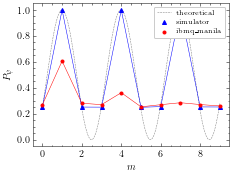

In [126]:
lim = 10

a = p_lst_sim[0]
theta = np.arcsin(np.sqrt(a))
m = np.arange(len(p_lst_sim[:lim]))
ms = np.linspace(m[0], m[-1], 1000)

# fig = plt.figure(figsize=(20, 10))
plt.xlabel(r'$m$')
plt.ylabel(r'$P_{\psi}$')
plt.plot(ms, np.sin((2*ms+1)*theta)**2, 'k--', lw=0.5, alpha=0.5, label='theoretical')
# plt.plot(m, p_lst_sim[:lim], 'b--', lw=0.5)

plt.plot(m, p_lst_sim[:lim], 'b-', lw=0.5)
plt.plot(m, p_lst_qc[:lim], 'r-', lw=0.5)

plt.plot(m, p_lst_sim[:lim], 'b^', ms=4, label='simulator')
plt.plot(m, p_lst_qc[:lim], 'r.', label='ibmq_manila')
# plt.axvline(x=np.floor(np.pi/(4*theta)), c='k', ls='--', label=r'$m_{floor}$')
# plt.axhline(y=max(a, 1-a), c='b', ls='--', label=r'max$(1-a,a)$')
plt.legend(loc='upper right', framealpha=1, frameon=True, fontsize='x-small')
plt.savefig('evolution', dpi=600)
for i in dir(plt)

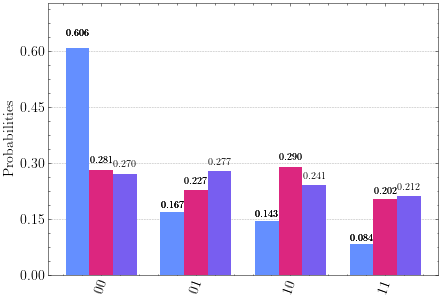

In [13]:
plot_histogram([counts[1], counts[2], counts[3]])

In [21]:
circ_lst = []

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qr, cr)

qc.compose(W, inplace=True)

qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure(qr, cr)
circ_lst.append(qc_measured)

for m in range(20):
    qc.compose(Q, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure(qr, cr)
    circ_lst.append(qc_measured)

In [33]:
shots = 20000
job = execute(circ_lst, backend=backend_qc, shots=shots) #61fbbf00742ae406e79ad455
print(job.job_id())

61fbbf00742ae406e79ad455


In [31]:
shots = 20000
job = execute(circ_lst, backend=backend_qc_sim, shots=shots)
counts = job.result().get_counts()

In [5]:
job = backend_qc.retrieve_job('61fbbf00742ae406e79ad455')
counts = job.result().get_counts()

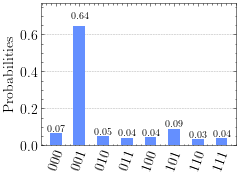

In [16]:
fig, axs = plt.subplots()
plot_histogram(flip_keys(counts[1]), ax=axs)
plt.savefig('histogram3qubit', dpi=600)

# N = 4 example

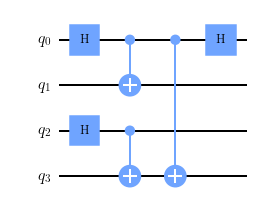

In [26]:
qr = QuantumRegister(2, 'q')
S = QuantumCircuit(qr)
S.x(qr)
S.h(1)
S.cnot(0, 1)
S.h(1)
S.x(qr)

qr = QuantumRegister(4, 'q')
S0 = QuantumCircuit(qr)
S0.x(qr)
S0.h(-1)
S0.compose(MCMT('x', 3, 1), inplace=True)
S0.h(-1)
S0.x(qr)

W = QuantumCircuit(4)
W.h([0, 2])
W.cx(0, 1)
W.cx(2, 3)
W.cx(0, -1)
W.h(0)
W.draw()

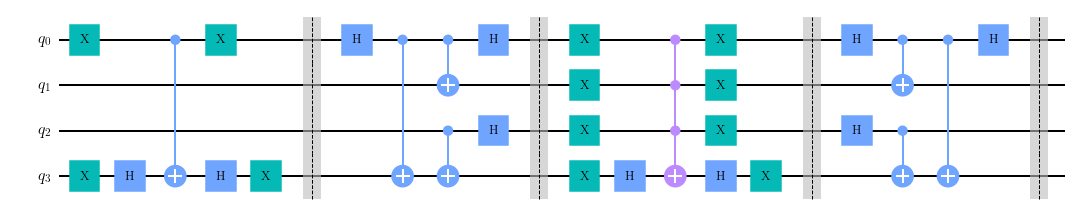

In [27]:
Q = QuantumCircuit(4)
Q.compose(S, [0, -1], inplace=True)
Q.barrier()
Q.compose(W.reverse_ops(), inplace=True)
Q.barrier()
Q.compose(S0, inplace=True)
Q.barrier()
Q.compose(W, inplace=True)
Q.barrier()
Q.draw()

In [28]:
Q = RemoveBarriers()(Q)

In [44]:
circ_lst = []

qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)

qc.compose(W, inplace=True)

qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure([qr[0], qr[-1]], cr)
circ_lst.append(qc_measured)

for m in range(20):
    qc.compose(Q, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure([qr[0], qr[-1]], cr)
    circ_lst.append(qc_measured)

In [45]:
shots = 20000
job = execute(circ_lst, backend=backend_sim, shots=shots)
counts = job.result().get_counts()
shots = sum(counts[0].values())
p_lst_sim = []

for dic in counts:
    p_lst_sim.append(dic.get('00', 0)/shots)

In [46]:
shots = 20000
job = execute(circ_lst, backend=backend_qc_sim, shots=shots)
print(job.job_id())

47ddeb2b-6122-4b51-9724-0e22f0140e97


In [47]:
# job = backend_qc.retrieve_job('61fa883011eec73fa9809418') # 61fa883011eec73fa9809418
counts = job.result().get_counts()
shots = sum(counts[0].values())
p_lst_qc = []

for dic in counts:
    p_lst_qc.append(dic.get('00', 0)/shots)

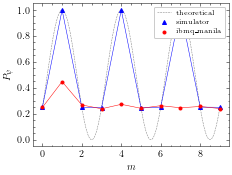

In [48]:
lim = 10

a = p_lst_sim[0]
theta = np.arcsin(np.sqrt(a))
m = np.arange(len(p_lst_sim[:lim]))
ms = np.linspace(m[0], m[-1], 1000)

# fig = plt.figure(figsize=(20, 10))
plt.xlabel(r'$m$')
plt.ylabel(r'$P_{\psi}$')
plt.plot(ms, np.sin((2*ms+1)*theta)**2, 'k--', lw=0.5, alpha=0.5, label='theoretical')
# plt.plot(m, p_lst_sim[:lim], 'b--', lw=0.5)

plt.plot(m, p_lst_sim[:lim], 'b-', lw=0.5)
plt.plot(m, p_lst_qc[:lim], 'r-', lw=0.5)

plt.plot(m, p_lst_sim[:lim], 'b^', ms=4, label='simulator')
plt.plot(m, p_lst_qc[:lim], 'r.', label='ibmq_manila')
# plt.axvline(x=np.floor(np.pi/(4*theta)), c='k', ls='--', label=r'$m_{floor}$')
# plt.axhline(y=max(a, 1-a), c='b', ls='--', label=r'max$(1-a,a)$')
plt.legend(loc='upper right', framealpha=1, frameon=True, fontsize='x-small')
# plt.savefig('evolution', dpi=600)

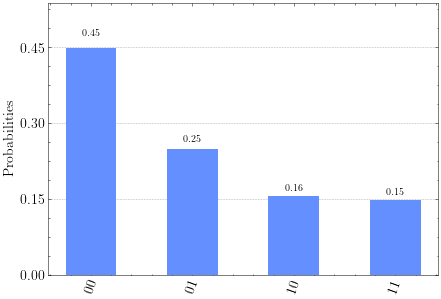

In [49]:
plot_histogram(flip_keys(counts[1]))

In [50]:
circ_lst = []

qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(4, 'c')
qc = QuantumCircuit(qr, cr)

qc.compose(W, inplace=True)

qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure(qr, cr)
circ_lst.append(qc_measured)

for m in range(20):
    qc.compose(Q, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure(qr, cr)
    circ_lst.append(qc_measured)

In [53]:
shots = 20000
job = execute(circ_lst, backend=backend_qc, shots=shots) # 61fbf040b0d8e127a3618939
print(job.job_id())

61fbf040b0d8e127a3618939


In [62]:
job = backend_qc.retrieve_job('61fbf040b0d8e127a3618939')
counts_qc = job.result().get_counts()

In [72]:
shots = 20000
job = execute(circ_lst, backend=backend_sim, shots=shots)
counts_sim = job.result().get_counts()

# shots = 20000
# job = execute(circ_lst, backend=backend_qc_sim, shots=shots)
# counts_qc = job.result().get_counts()

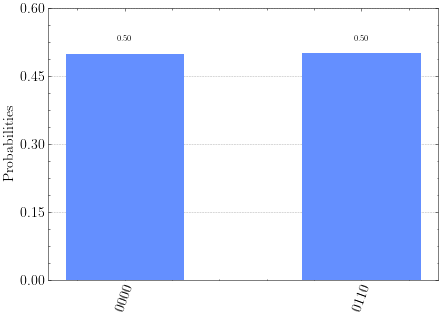

In [73]:
plot_histogram(flip_keys(counts_sim[1]))

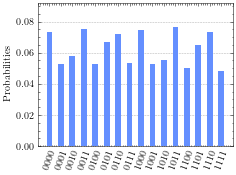

In [71]:
fig, ax = plt.subplots()
plot_histogram(flip_keys(counts_qc[1]), bar_labels=False, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.savefig('histogram4qubit', dpi=600)